# **The Stokes equations**
**Kevin Arnmark**

# **Abstract**

This report demonstrates a method of simulating viscous flow using FEniCS to solve the Stokes equations. It includes visualizations of the effects of not fulfilling the inf-sup conditions as well as the effects of reversing the flow in the simulation.

# **About the code**

In [ ]:
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

# Background

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 

# Lab assignments

In this report I will implement the following points and answer the following questions:

1. The domain

  Change the computational domain into a channel with only one circular hole at the center of the channel.

2. The mesh  

  Change the resolution of the mesh to a uniform mesh size of h=1/32. Then locally refine the mesh once in a circle of radius 1 centered at the circular hole. 

3. The inf-sup condition

  Verify that the Taylor-Hood mixed element is stable, whereas equal order interpolation of the velocity and pressure is unstable. Describe how the instability manifests itself. 

  The inf-sup condition:
  
  $\inf_{q \in Q} \sup_{v \in V} \frac{b(v,q)}{\lvert\lvert v \rvert \rvert_V  \lvert\lvert q \rvert \rvert_Q} \geq \beta > 0$

4. Boundary conditions (Extra)

  Switch the  inflow and outflow boundaries so that the fluid flows from right to left. Describe how the pressure changes. 

# **Method**

**Define domain and mesh**

The domain is a rectangle with length 4 and height 2 with a circle subtracted from the center point of the rectangle. The mesh is generated with a resolution of 32. The mesh is then refined once in an area defined by a circle with a center point in the middle of the mesh with a radius of 1. 

Refining the mesh is done by checking which cells are inside the area we want to refine, and then calling the function refine() with the mesh and markers specifying where to refine it.

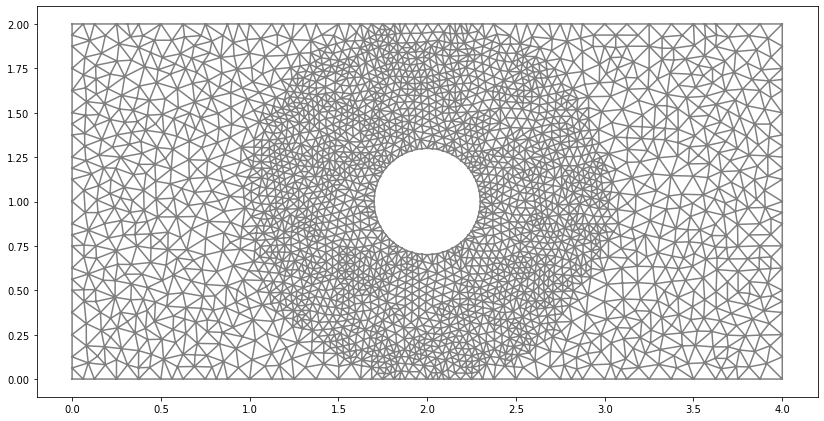

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.3, 32), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L,0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure(figsize=(14,10))
plot(mesh)
plt.show()

**Define finite element approximation spaces**

When defining the approximation spaces it is important to ensure they meet the inf-sup condition. 

Taylor-Hood elements are the continuous piecewise quadratic approximation of the velocity and continuous piecewise linear approximation of the pressure, according to the lecture notes chapter 5.3. The Taylor-Hood elements are one example of approximation spaces that satisfies the inf-sup condition. It is implemented below as:

  `VE = VectorElement("CG", mesh.ufl_cell(), 2)`

  `QE = FiniteElement("CG", mesh.ufl_cell(), 1)`

  Where CG means Continous Galerkin.

  Choosing the same order of approximation spaces does not fullfill the inf-sup condition which makes the result unstable.

The following code generates the approximation spaces using both Taylor-Hood elements and the unstable ones as well as defining trial and test functions for both. I also define trial and test functions that are going to be used when doing the reversed flow. I am using the Taylor-Hood elements in the reversed flow.

In [ ]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

# Define trial and test functions (reversed flow)
w_r = Function(W)
(u_r, p_r) = (as_vector((w_r[0],w_r[1])), w_r[2])
(v_r, q_r) = TestFunctions(W) 

# Generate unstable mixed finite element spaces (for velocity and pressure)
VE2 = VectorElement("CG", mesh.ufl_cell(), 1)
QE2 = FiniteElement("CG", mesh.ufl_cell(), 1)
WE2 = VE2 * QE2

W2 = FunctionSpace(mesh, WE2)
V2 = FunctionSpace(mesh, VE2)
Q2 = FunctionSpace(mesh, QE2)

# Define trial and test functions
w2 = Function(W2)
(u2, p2) = (as_vector((w2[0],w2[1])), w2[2])
(v2, q2) = TestFunctions(W2) 

**Define boundary conditions**

The inflow boundary is choosen to be at x = 0 and the outflow boundary is at the rightmost part of the mesh (x = 4). The stress at these points are set to zero to model an emptiness as to not disturb the flow. The top and bottom of the rectangle, or the walls are defined to set the velocity to zero in both the tangental and orthogonal directions. This is also called a non-slip boundary condition.

This is done for both the stable and unstable choices of approximation spaces as well as one for the reversed flow. 

Changing the flow from left to right can be done by switching the position of the inflow and outflow boundary conditions and defining the uin expression to have a negative value.

In [ ]:
# Inflow and outflow conditions with Taylor-Hood elements
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())


# Switched inflow and outflow boundaries to reverse the flow
uin_r = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
ib_r = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
ob_r = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())


# Inflow, outflow conditions with same order approximation space 
uin2 = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V2.ufl_element())

# Inflow boundary (ib2), outflow boundary (ob2) and wall boundary (wb2)
ib2 = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q2.ufl_element())
ob2 = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q2.ufl_element())
wb2 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q2.ufl_element())

# **Results**

**Define and solve variational problem**
The following code defines the residual and solves the algebraic system for all three variations of the problem (Taylor-Hood elements, unstable and reversed flow).

In [ ]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0 (Taylor-Hood)
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx)

# Solve algebraic system (Taylor-Hood)
solve(residual == 0, w)

# Define variational problem on residual form: r(u,p;v,q) = 0 (Reversed flow)
residual_r = ( - p_r*div(v_r)*dx + inner(grad(u_r), grad(v_r))*dx + div(u_r)*q_r*dx + 
            gamma*(ib_r*inner(u_r - uin_r, v_r) + wb*inner(u_r, v_r))*ds - inner(f, v_r)*dx)

# Solve algebraic system (Reversed flow)
solve(residual_r == 0, w_r)

f2 = Expression(("0.0","0.0"), element = V2.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0 (Unstable)
residual2 = ( - p2*div(v2)*dx + inner(grad(u2), grad(v2))*dx + div(u2)*q2*dx + 
            gamma*(ib2*inner(u2 - uin2, v2) + wb2*inner(u2, v2))*ds - inner(f2, v2)*dx)

# Solve algebraic system (Unstable)
solve(residual2 == 0, w2)

**Visualize solution and export files**

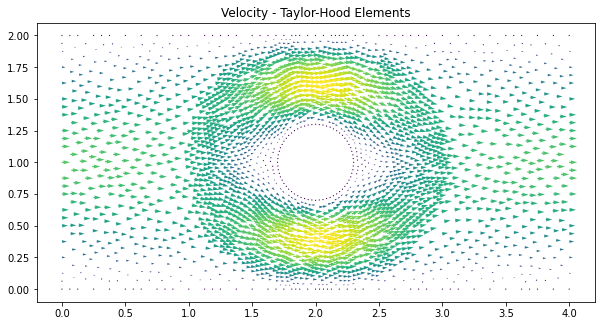

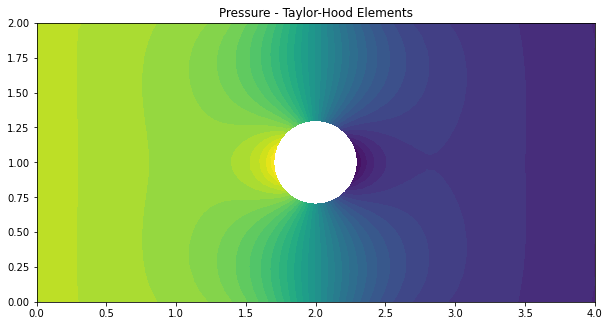

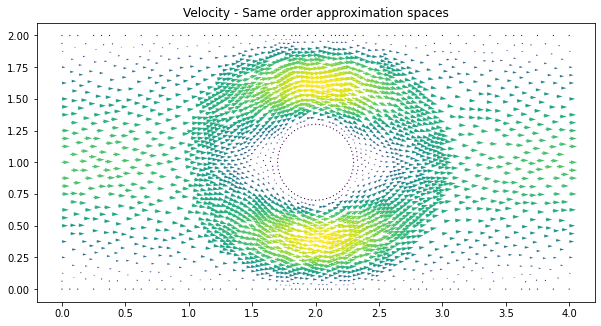

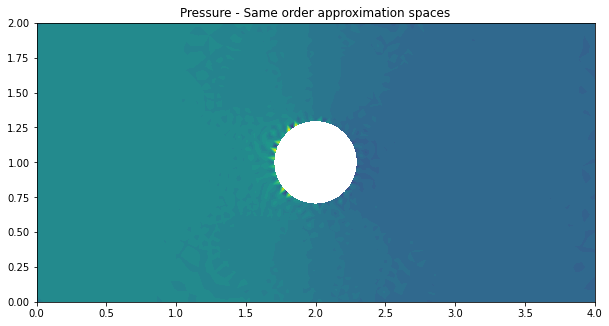

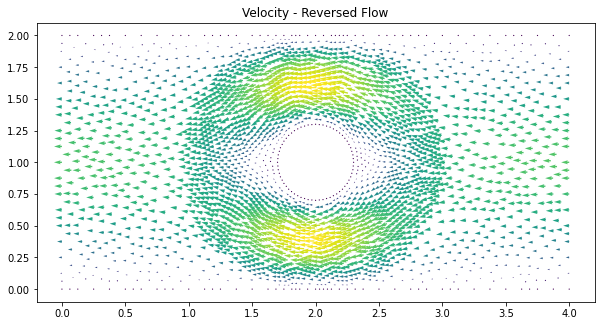

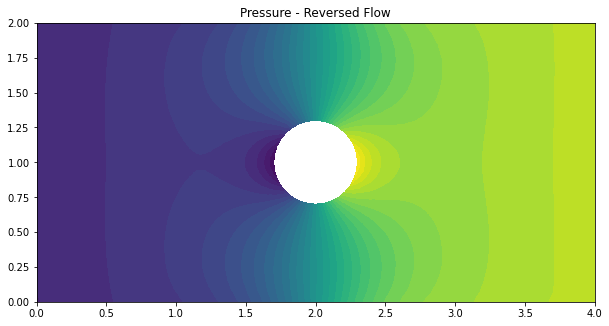

In [ ]:
!rm results-Stokes/*

# Taylor-Hood elements visulizaiton
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Stokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure(figsize=(10,10))
plot(u1, title="Velocity - Taylor-Hood Elements")

plt.figure(figsize=(10,10))
plot(p1, title="Pressure - Taylor-Hood Elements")
        
plt.show()


# Unstable visualization
file_u2 = File("results-Stokes/u2.pvd")
file_p2 = File("results-Stokes/p2.pvd")

u2 = project(u2, V2)
p2 = project(p2, Q2)

# Save solution to file
file_u2 << u2
file_p2 << p2

# Plot solution
plt.figure(figsize=(10,10))
plot(u2, title="Velocity - Same order approximation spaces")

plt.figure(figsize=(10,10))
plot(p2, title="Pressure - Same order approximation spaces")
        
plt.show()


# Reverse flow visualization
file_u_r = File("results-Stokes/u_r.pvd")
file_p_r = File("results-Stokes/p_r.pvd")

u1_r = project(u_r, V)
p1_r = project(p_r, Q)

# Save solution to file
file_u << u1_r
file_p << p1_r

# Plot solution
plt.figure(figsize=(10,10))
plot(u1_r, title="Velocity - Reversed Flow")

plt.figure(figsize=(10,10))
plot(p1_r, title="Pressure - Reversed Flow")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-Stokes
#files.download('results-Stokes.tar.gz')

# **Discussion**

The solution using the Taylor-hood elements is stable and behaves as expected, which can be seen in both the velocity and pressure. The solution using the same order approximation spaces looks like the Taylor-hood solution when looking at the velocity, but the pressure is different. The instability manifest itself by oscillating, creating the pattern visible in the figure.

The result of changing the flow from left to right is mirrored at x = 2 since the mesh is symmetric. So the high pressure that can be seen on the left side of the rectangle in the left to right flow is now on the right side.